In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
def mandelbrot_kernel(c, max_iters): 
  z = c
  nv = 0
  for i in range(max_iters):
    if abs(z) > 2:
      break
    z = z*z + c
    nv += 1
  return nv

In [3]:
def compute_mandelbrot(min_x, max_x, min_y, max_y, width, height, iters):
    # create a matrix. Each element of the matrix corresponds to a pixel
    t = [[0 for _ in range(width)] for _ in range(height)]

    dx = (max_x - min_x) / width
    dy = (max_y - min_y) / height

    y = min_y
    for row in range(height):
        x = min_x
        for col in range(width):
            t[row][col] = mandelbrot_kernel(complex(x, y), iters)
            x += dx
        y += dy
    return np.array(t)

In [4]:
def show_plot(numpy_array):
    scale = 10
    dpi = 64

    height, width = numpy_array.shape
    fig = plt.figure(1, [scale, scale * height // width], dpi)
    ax = fig.add_axes([0.0, 0.0, 1.0, 1.0], False, 1)
    light = colors.LightSource(315, 10, 0, 1, 1, 0)

    image = light.shade(numpy_array, plt.cm.hot, colors.PowerNorm(0.3), "hsv", 0, 0, 1.5)
    plt.imshow(image)
    plt.axis("off")
    plt.show()

In [5]:
width = 960
height = 960
min_x = -2.0
max_x = 0.6
min_y = -1.5
max_y = 1.5
iters = 200

In [6]:
tensor = []
%timeit -n 1 -r 1 tensor.append(compute_mandelbrot(min_x, max_x, min_y, max_y, width, height, iters))
tensor = tensor[0]

6.36 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/var/folders/n_/c45wnr0166jdp717h72v_nq0n9hhqk/T/ipykernel_64173/374381006.py:7: MatplotlibDeprecationWarning: Passing more than one positional argument to Figure.add_axes was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Any additional positional arguments are currently ignored.
  ax = fig.add_axes([0.0, 0.0, 1.0, 1.0], False, 1)


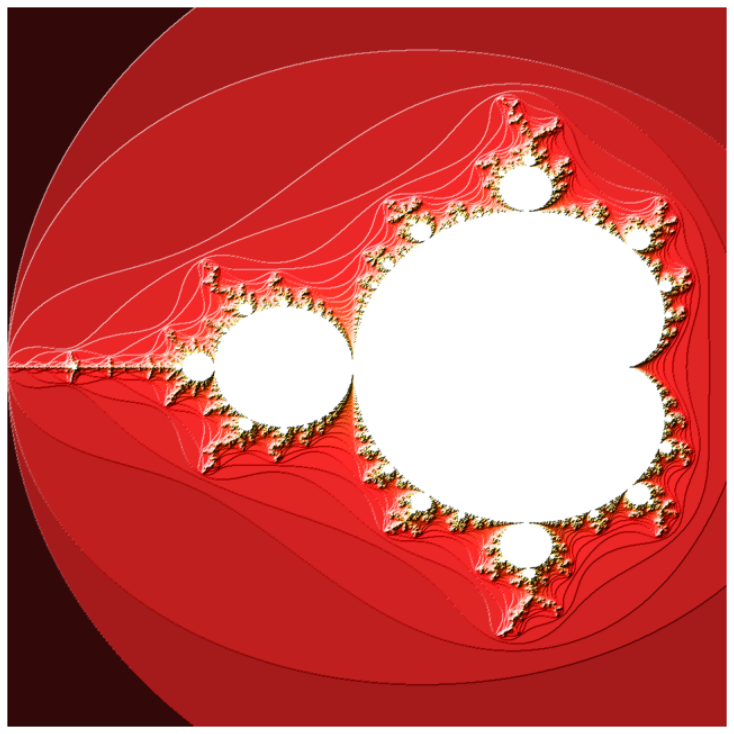

In [7]:
show_plot(tensor)

In [8]:
# This is slower
def compute_mandelbrot_np(min_x, max_x, min_y, max_y, width, height, iters):
    # create a matrix. Each element of the matrix corresponds to a pixel
    x = np.linspace(min_x, max_x, width).reshape((1, width))
    y = np.linspace(min_y, max_y, height).reshape((height, 1))
    C = np.tile(x, (height, 1)) + 1j * np.tile(y, (1, width))

    v_mandelbrot_kernel = np.vectorize(pyfunc=mandelbrot_kernel)
    return v_mandelbrot_kernel(C, iters)

# This is much faster, but only return a bit map
def compute_mandelbrot_np2(min_x, max_x, min_y, max_y, width, height, iters):
    # create a matrix. Each element of the matrix corresponds to a pixel
    x = np.linspace(min_x, max_x, width).reshape((1, width))
    y = np.linspace(min_y, max_y, height).reshape((height, 1))
    C = np.tile(x, (height, 1)) + 1j * np.tile(y, (1, width))
    
    Z = np.zeros((height, width), dtype=complex)
    M = np.full((height, width), True, dtype=bool)
    for i in range(iters):
        Z[M] = Z[M] * Z[M] + C[M]
        M[np.abs(Z) > 2] = False
    return np.uint8(np.flipud(1 - M) * 255)

In [9]:
tensor = []
%timeit -n 1 -r 1 tensor.append(compute_mandelbrot_np2(min_x, max_x, min_y, max_y, width, height, iters))
tensor = tensor[0]

1.72 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/var/folders/n_/c45wnr0166jdp717h72v_nq0n9hhqk/T/ipykernel_64173/374381006.py:7: MatplotlibDeprecationWarning: Passing more than one positional argument to Figure.add_axes was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Any additional positional arguments are currently ignored.
  ax = fig.add_axes([0.0, 0.0, 1.0, 1.0], False, 1)


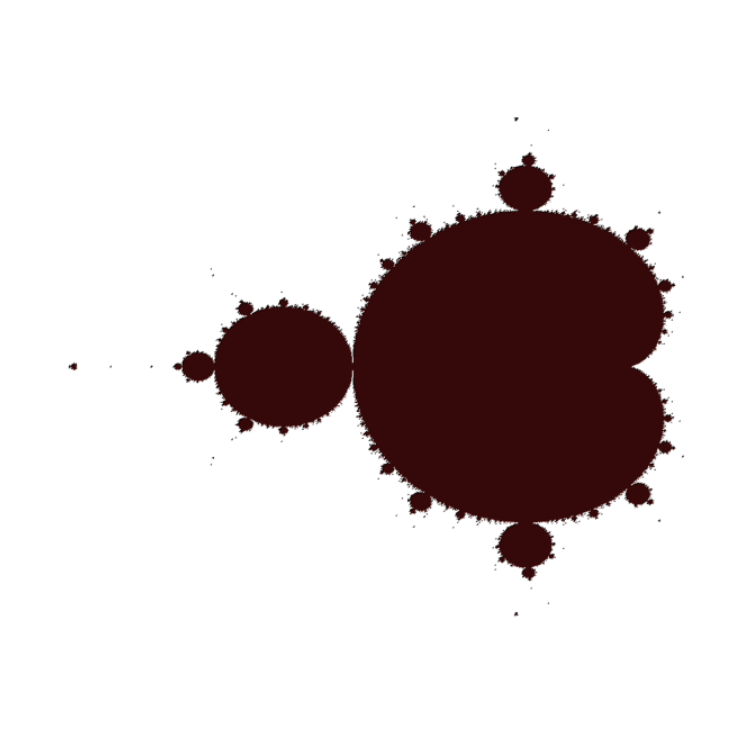

In [10]:
show_plot(tensor)

In [11]:
from numba import jit, int32, complex128
import numpy as np

@jit(nopython=True)
def mandelbrot_kernel_nb(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    nv = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z * z + c
        if (z.real * z.real + z.imag * z.imag) >= 4:
            break
        nv += 1
    return nv

@jit(nopython=True)
def compute_mandelbrot_nb(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    dx = (max_x - min_x) / width
    dy = (max_y - min_y) / height

    y = min_y
    for row in range(height):
        x = min_x
        for col in range(width):
            image[row][col] = mandelbrot_kernel_nb(x, y, iters)
            x += dx
        y += dy
    return image

In [12]:
tensor = []
image = np.zeros((height, width), dtype=np.uint8)
%timeit -n 1 -r 1 tensor.append(compute_mandelbrot_nb(min_x, max_x, min_y, max_y, image, iters))
tensor = tensor[0]

485 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/var/folders/n_/c45wnr0166jdp717h72v_nq0n9hhqk/T/ipykernel_64173/374381006.py:7: MatplotlibDeprecationWarning: Passing more than one positional argument to Figure.add_axes was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Any additional positional arguments are currently ignored.
  ax = fig.add_axes([0.0, 0.0, 1.0, 1.0], False, 1)


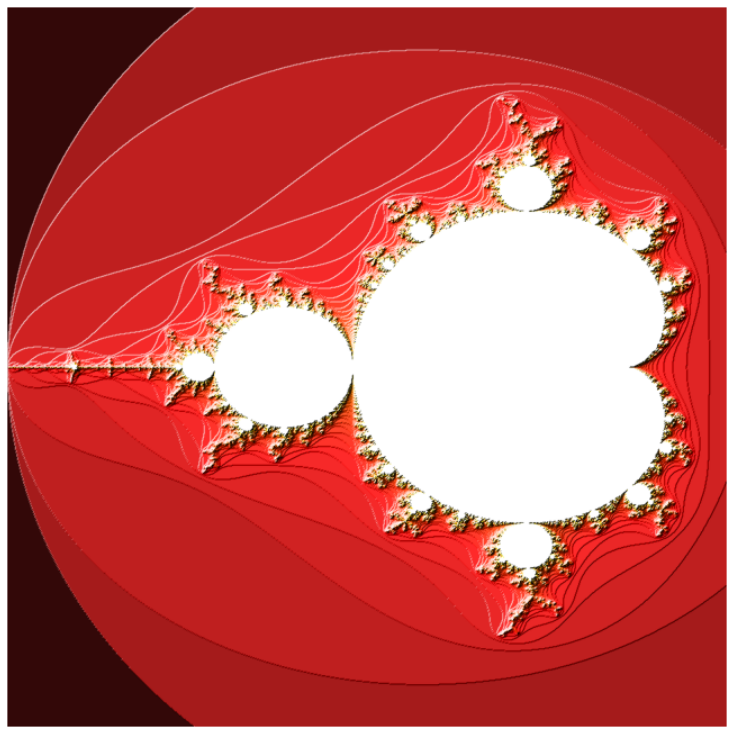

In [13]:
show_plot(tensor)

In [14]:
import mandelbrot

In [15]:
image = np.zeros((height, width), dtype=np.uint8)
%timeit -n 1 -r 1 mandelbrot.compute_mandelbrot_rs(min_x, max_x, min_y, max_y, width, height, image, iters)

144 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/var/folders/n_/c45wnr0166jdp717h72v_nq0n9hhqk/T/ipykernel_64173/374381006.py:7: MatplotlibDeprecationWarning: Passing more than one positional argument to Figure.add_axes was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Any additional positional arguments are currently ignored.
  ax = fig.add_axes([0.0, 0.0, 1.0, 1.0], False, 1)


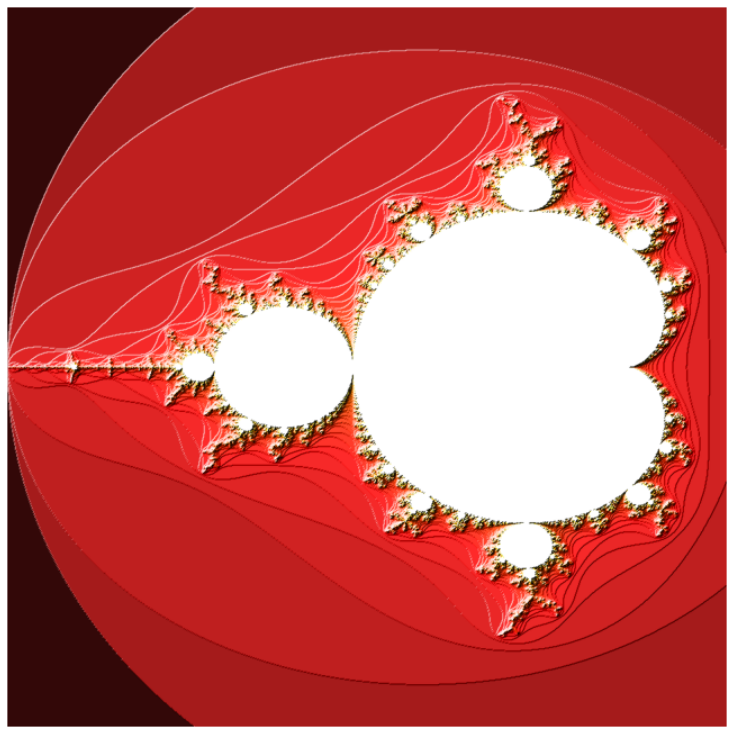

In [16]:
show_plot(image)

In [17]:
tensor = []
%timeit -n 1 -r 1 tensor.append(mandelbrot.compute_mandelbrot_rs_par(min_x, max_x, min_y, max_y, width, height, iters))
tensor = tensor[0]

18.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/var/folders/n_/c45wnr0166jdp717h72v_nq0n9hhqk/T/ipykernel_64173/374381006.py:7: MatplotlibDeprecationWarning: Passing more than one positional argument to Figure.add_axes was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Any additional positional arguments are currently ignored.
  ax = fig.add_axes([0.0, 0.0, 1.0, 1.0], False, 1)


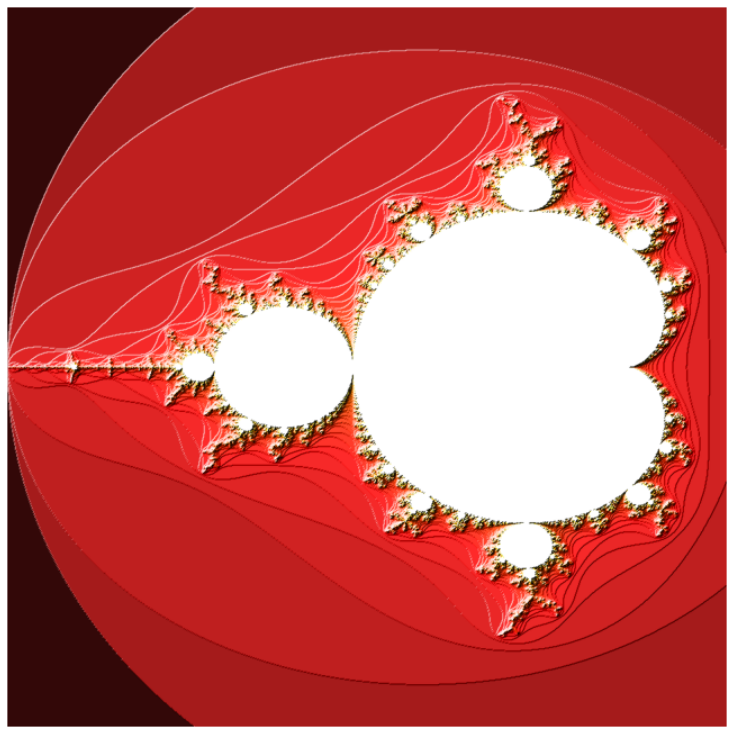

In [18]:
show_plot(image)

In [19]:
tensor = []
%timeit -n 1 -r 1 tensor.append(mandelbrot.compute_mandelbrot_rs_simd_par(min_x, max_x, min_y, max_y, width, height, iters))
tensor = tensor[0]

4.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/var/folders/n_/c45wnr0166jdp717h72v_nq0n9hhqk/T/ipykernel_64173/374381006.py:7: MatplotlibDeprecationWarning: Passing more than one positional argument to Figure.add_axes was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Any additional positional arguments are currently ignored.
  ax = fig.add_axes([0.0, 0.0, 1.0, 1.0], False, 1)


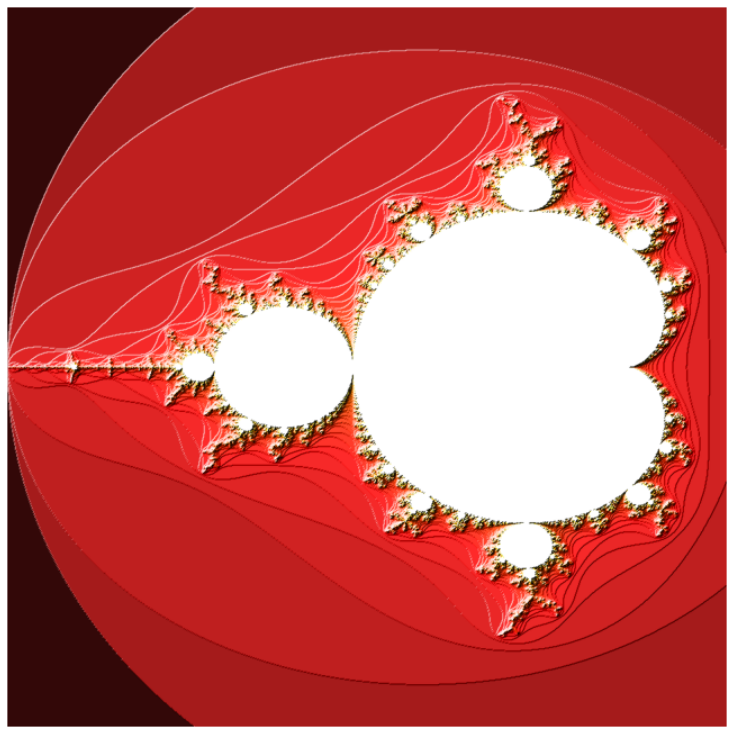

In [20]:
show_plot(image)